In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

In [2]:
num_epochs = 20
batch_size = 64
learning_rate = 0.001

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)


100%|██████████| 170498071/170498071 [00:02<00:00, 79291374.68it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


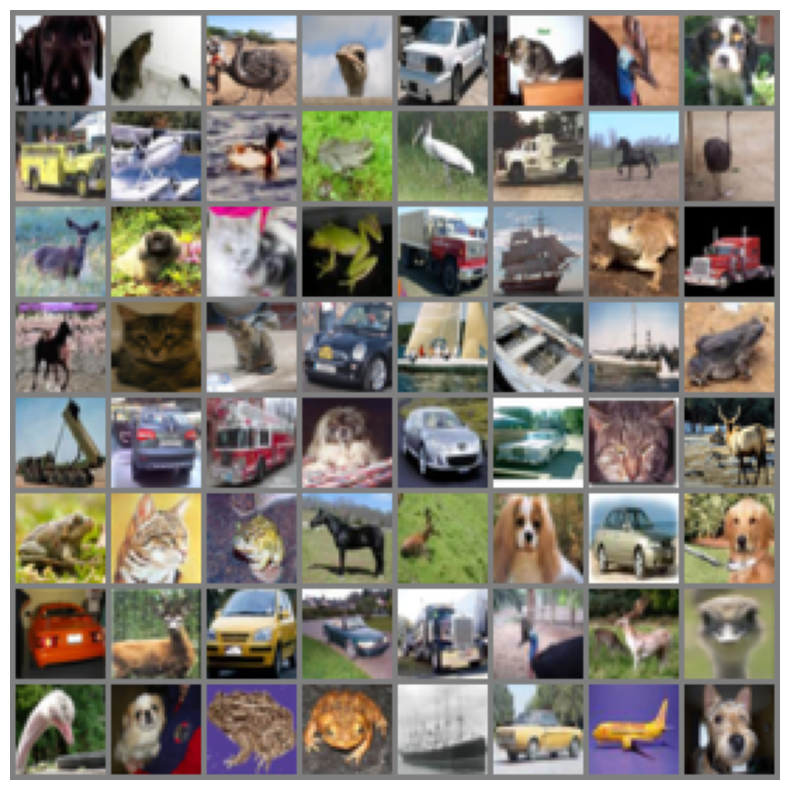

In [12]:
import numpy as np

# Get some random training images
data_iter = iter(train_loader)
images, labels = next(data_iter)


# Create a grid of images
img_grid = torchvision.utils.make_grid(images)   # stacks the images side by side, separating them with white space.

# Unnormalize the images for display
img_grid = img_grid / 2 + 0.5     #  they were normalized to have pixel values between -1 and 1 (mean 0 and standard deviation 1). By dividing by 2 and adding 0.5, it reverses this normalization, bringing the pixel values back to the range [0, 1].
npimg = img_grid.numpy()   #  is required for displaying the image using Matplotlib.

# Show the grid of images
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.axis('off')
plt.show()


In [17]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer3 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(4 * 4 * 64, 512)
    self.fc2 = nn.Linear(512, 128)
    self.fc3 = nn.Linear(128, 32)
    self.fc4 = nn.Linear(32, 10)

  def forward(self, x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = self.layer3(out)
      # print('out',out)
      out = out.reshape(out.size(0), -1)
      out = self.drop_out(out)
      out = self.fc1(out)
      out = self.fc2(out)
      out = self.fc3(out)
      out = self.fc4(out)
      return out

In [18]:
model = ConvNet()

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1) # find the class with the highest score (the predicted class) for each input in the batch
        # print('torch max', torch.max(outputs.data, 1))
        correct = (predicted == labels).sum().item()

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/20], Step [100/782], Loss: 1.8351, Accuracy: 26.56%
Epoch [1/20], Step [200/782], Loss: 1.6115, Accuracy: 34.38%
Epoch [1/20], Step [300/782], Loss: 1.6691, Accuracy: 48.44%
Epoch [1/20], Step [400/782], Loss: 1.4011, Accuracy: 50.00%
Epoch [1/20], Step [500/782], Loss: 1.4637, Accuracy: 50.00%
Epoch [1/20], Step [600/782], Loss: 1.2484, Accuracy: 48.44%
Epoch [1/20], Step [700/782], Loss: 1.3576, Accuracy: 54.69%
Epoch [2/20], Step [100/782], Loss: 1.0947, Accuracy: 54.69%
Epoch [2/20], Step [200/782], Loss: 1.3499, Accuracy: 54.69%
Epoch [2/20], Step [300/782], Loss: 1.2819, Accuracy: 51.56%
Epoch [2/20], Step [400/782], Loss: 1.4705, Accuracy: 45.31%
Epoch [2/20], Step [500/782], Loss: 1.0965, Accuracy: 60.94%
Epoch [2/20], Step [600/782], Loss: 1.2168, Accuracy: 53.12%
Epoch [2/20], Step [700/782], Loss: 1.0553, Accuracy: 59.38%
Epoch [3/20], Step [100/782], Loss: 1.2706, Accuracy: 51.56%
Epoch [3/20], Step [200/782], Loss: 1.0941, Accuracy: 62.50%
Epoch [3/20], Step [300/

In [61]:
model.eval()
results = []
image_list = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        results.append(predicted)
        image_list.append(images)

    print('Test Accuracy of the model on the test images: {} %'.format((correct / total) * 100))


Test Accuracy of the model on the test images: 74.65 %


(64, 3, 32, 32)
(32, 32, 3)


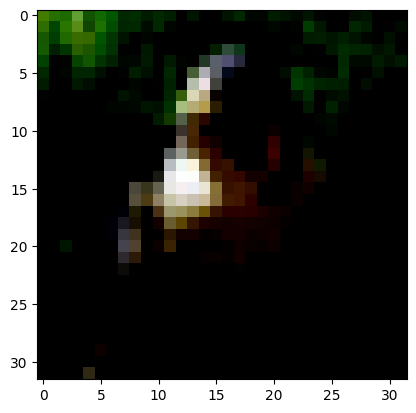

In [63]:
img_np = image_list[6].numpy()
print(img_np.shape)

img_np = image_list[6][0, :, :, :].numpy().transpose((1, 2, 0))
print(img_np.shape)
plt.imshow(img_np)
plt.show()

In [65]:
results[6][0]

tensor(2)

In [66]:
# Saving the model
torch.save(model.state_dict(), 'best_model.pth')